# making an aggregate master dataframe for baseline model  10/22/18 -11/6/18
this notebook is going to make standardized longformat dataframes for each dataframe that i will adjust for each model to. 

for my first pass, i will work to establish a baseline model by using:
the single "worst", or value that most indicates poor clinical outcomes, for each variable so each variable only has one row per patient. 


- make a long format table(ie variable, patient, time, value)
 - step1:Standardize all columns, format, etc. 
 - step2: Maybe make a long format table for each dataframe
 - step3: Impute
 
- combine features from each long table for 1 wide table (ie each patient has a row, each parameter has a column). 
 - feature select for "Clinical worst case" 



- Establish a baseline (ie train model initially), using an obvious baseline: last valid mesurement of a particular variable.   Will hope that it doesn’t perform too good or too bad. Second would be to pick an aggregate within a time window (over 3 days, or of each day, ie can change graunlarity).

- Next try temporal trend, maybe vector autoregression. 

So my first step would be to pick either the last recorded value for each variable or the ‘worst’ value, or ones that we might expect to indicate poor outcome (NEED TO CHOOSE)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

In [2]:
#cohort import
from pathlib import Path
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

date='25012019'
final_pt_df2 = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/25012019_final_pt_df2_v.csv', index_col=0) #final cohort for PA 

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 61.6 ms


In [3]:
#adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
import psycopg2
import getpass
conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 23.2 s


In [141]:
#importing in all clinical_variable files
date= '25012019'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/')
allFiles = glob.glob(os.getcwd() + "/{}_*.csv".format(date))

time: 2.38 ms


In [142]:
os.getcwd()

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project'

time: 1.74 ms


In [143]:
allFiles  #need to rerun 03.1-clinical_variables and have a new date to make it easier. 

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_pt_info_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_nit_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_bg_ART_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_leuk_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_ventcategory_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_epinephrine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_height_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/PA_project/25012019_labs_prepped.csv',
 '/Users/geickelb1/

time: 2.86 ms


In [144]:
#making a dictionary of all my dataframes for easier cycling through

df_list=[]
for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0]) #making an list of all my dataframes in order they appear in file

dfs = {}
i=0
for name in df_list:
    dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 5.17 s


In [145]:
#folder to save files to:
save_date= '25012019'
save_path= wd+'/data/processed/PA_project/merged'

def save_df(df, df_name='default'):
    if df_name == 'default':
        df_name= "%s"%(df)
    pd.DataFrame(df).to_csv(Path(save_path+'/%s_%s_prepped.csv' %(save_date, df_name)))
    del(df)

time: 3.44 ms


# import all clinical variables
##ensure they are the versions with UOM

In [146]:
#all of the column names 
for element in df_list:
    print(element,':',list(dfs[element]))

pt_info : ['icustay_id', 'subject_id', 'first_pos_else_neg_ssc', 'label', 'value', 'delta', 'uom']
nit : ['hadm_id', 'icustay_id', 'subject_id', 'first_pos_else_neg_ssc', 'delta', 'value', 'label', 'uom']
bg_ART : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 'first_pos_else_neg_ssc', 'label', 'valuenum', 'uom']
leuk : ['hadm_id', 'icustay_id', 'subject_id', 'first_pos_else_neg_ssc', 'delta', 'value', 'label', 'uom']
ventcategory : ['icustay_id', 'delta', 'value', 'uom', 'first_pos_else_neg_ssc', 'label']
epinephrine : ['icustay_id', 'first_pos_else_neg_ssc', 'value', 'label', 'uom', 'delta']
height : ['icustay_id', 'value', 'uom', 'label', 'delta', 'first_pos_else_neg_ssc']
labs : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'label', 'value', 'uom', 'first_pos_else_neg_ssc', 'delta']
phenylephrine : ['icustay_id', 'first_pos_else_neg_ssc', 'value', 'label', 'uom', 'delta']
vasopressin : ['icustay_id', 'first_pos_else_neg_ssc', 'value', 'label', 'uom', 'delta']


## standardizing columns

#### adding icustay_id, dropping hadm_id

In [147]:
##dropping hadm_id from all:
list1=[]
for element in df_list:
    if 'hadm_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('hadm_id', axis=1)

time: 234 ms


In [148]:
##dropping subject_id from all:
list1=[]
for element in df_list:
    if 'subject_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('subject_id', axis=1)

time: 157 ms


In [149]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

pt_info : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
nit : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
bg_ART : ['charttime', 'delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'valuenum']
leuk : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
ventcategory : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
epinephrine : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
height : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
labs : ['charttime', 'delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
phenylephrine : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
vasopressin : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
weight : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'uom', 'value']
rrt : ['delta', 'first_pos_els

In [150]:
#dropping charttime, endtime and first_charttime

list1=[]
list2=[]
for element in df_list:
    if 'charttime' in (list(dfs[element])):
        list1.append(element)
    if 'endtime' in (list(dfs[element])):
        list2.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('charttime', axis=1)

for element in list2:
    dfs[element]= dfs[element].drop('endtime', axis=1)
    
#dfs['rrt']= dfs['rrt'].drop('first_charttime', axis=1)

time: 150 ms


In [151]:
#converting valuenum and value to same label
list1=[]

for element in df_list:
    if 'valuenum' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].rename(index=str, columns={'valuenum':'value'})


time: 89.6 ms


In [152]:
def label_lower(df_name):
    dfs[df_name]['label']= dfs[df_name]['label'].apply(lambda x: x.lower())

time: 1.18 ms


In [153]:
#turning all labels to lowercase
for element in df_list:
    label_lower(element)


time: 1.12 s


In [154]:
#adding a df source table label to each df. 
for element in df_list:
    dfs[element]['source']=element

#adding a patient id to each

for element in df_list:
    dfs[element]= pd.merge(dfs[element], final_pt_df2[['icustay_id','subject_id']], how='left')
    

time: 1.48 s


In [155]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

pt_info : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
nit : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
bg_ART : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
leuk : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
ventcategory : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
epinephrine : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
height : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
labs : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
phenylephrine : ['delta', 'first_pos_else_neg_ssc', 'icustay_id', 'label', 'source', 'subject_id', 'uom', 'value']
vasopressin : ['

In [156]:
for element in df_list:
    print(element)
    print(dfs[element]['label'].value_counts())#,':',sorted(list(dfs[element])))

pt_info
ethnicity          8629
first_admit_age    8629
gender             8629
Name: label, dtype: int64
nit
nitrite    8629
Name: label, dtype: int64
bg_ART
pco2    19945
Name: label, dtype: int64
leuk
leukocyte    8629
Name: label, dtype: int64
ventcategory
vent_recieved    8391
Name: label, dtype: int64
epinephrine
epinephrine    9277
Name: label, dtype: int64
height
height    5689
Name: label, dtype: int64
labs
potassium      38885
glucose        36551
sodium         33210
chloride       32107
hemoglobin     30354
creatinine     29365
bun            29249
bicarbonate    28894
platelet       27081
wbc            26418
lactate        21292
ptt            20724
inr            20103
bilirubin      10640
bands           2956
Name: label, dtype: int64
phenylephrine
phenylephrine    14885
Name: label, dtype: int64
vasopressin
vasopressin    9979
Name: label, dtype: int64
weight
weight    7854
Name: label, dtype: int64
rrt
rrt    8629
Name: label, dtype: int64
pafaRatio
pao2/fio2    8629


In [160]:
dfs['o2_flow']

,icustay_id,first_pos_else_neg_ssc,value,label,uom,delta,source,subject_id
0,240363.0,2115-09-14 19:25:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3281
1,220265.0,2123-07-24 09:30:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3277
2,224362.0,2168-08-31 00:00:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3276
3,278829.0,2193-08-28 09:30:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3267
4,271485.0,2137-04-03 23:30:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3266
5,206821.0,2169-10-08 05:00:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3248
6,287365.0,2128-07-19 10:27:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3217
7,287757.0,2196-06-10 04:14:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3210
8,273606.0,2161-03-22 16:43:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3191
9,245726.0,2111-01-05 21:57:00,0.0,o2_flow,y/n,0 days 00:00:00.000000000,o2_flow,3179


time: 43.9 ms


# converting data formats

In [161]:
#na

time: 774 µs


# looking at measured values

In [162]:
df_list

['pt_info',
 'nit',
 'bg_ART',
 'leuk',
 'ventcategory',
 'epinephrine',
 'height',
 'labs',
 'phenylephrine',
 'vasopressin',
 'weight',
 'rrt',
 'pafaRatio',
 'o2_flow',
 'vitals',
 'dobutamine',
 'gcs',
 'bg_all',
 'norepinephrine',
 'dopamine',
 'sofa']

time: 2.27 ms


In [163]:
def value_viewer(df_name):
    return(dfs[df_name]['label'].unique())

time: 1.56 ms


In [164]:
value_viewer('bg_ART')

array(['pco2'], dtype=object)

time: 7.04 ms


In [165]:
value_viewer('bg_all')

array(['calcium', 'lactate', 'ph', 'temperature', 'hemoglobin', 'glucose',
       'bicarbonate', 'potassium', 'sodium', 'chloride'], dtype=object)

time: 13 ms


In [166]:
#value_viewer('uti')

time: 840 µs


In [167]:
value_viewer('labs')


array(['sodium', 'bicarbonate', 'chloride', 'creatinine', 'glucose',
       'potassium', 'bun', 'hemoglobin', 'inr', 'platelet', 'ptt', 'wbc',
       'lactate', 'bilirubin', 'bands'], dtype=object)

time: 30.3 ms


In [168]:
value_viewer('vitals')

array(['meanartpress', 'sysbp', 'heartrate', 'resprate', 'spo2',
       'temperature', 'glucose', 'diasbp'], dtype=object)

time: 137 ms


In [169]:
list(dfs)

['pt_info',
 'nit',
 'bg_ART',
 'leuk',
 'ventcategory',
 'epinephrine',
 'height',
 'labs',
 'phenylephrine',
 'vasopressin',
 'weight',
 'rrt',
 'pafaRatio',
 'o2_flow',
 'vitals',
 'dobutamine',
 'gcs',
 'bg_all',
 'norepinephrine',
 'dopamine',
 'sofa']

time: 4.9 ms


# combining data

In [170]:
set(value_viewer('labs')) & set(value_viewer('bg_all'))

{'bicarbonate',
 'chloride',
 'glucose',
 'hemoglobin',
 'lactate',
 'potassium',
 'sodium'}

time: 60.3 ms


In [171]:
set(value_viewer('labs')) & set(value_viewer('vitals'))

{'glucose'}

time: 157 ms


In [172]:
set(value_viewer('bg_all')) & set(value_viewer('vitals'))

{'glucose', 'temperature'}

time: 126 ms


In [173]:
# (dfs['labs'].loc[
#     dfs['labs'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 871 µs


In [174]:
# (dfs['vitals'].loc[
#     dfs['vitals'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1.57 ms


In [175]:
# (dfs['bg_all'].loc[
#     dfs['bg_all'].loc[:,'label']=='glucose', ['label','valuenum']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 2.68 ms


### merging labs together

In [176]:
# lab_bg_vital= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 971 µs


In [177]:
# lab_bg_vital.head()

time: 1.16 ms


In [178]:
# #rounding timedeltas to the 2 minute mark. 
# #pd.to_datetime(lab_bg_vital['delta'])#.dt.round('m')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])
# lab_bg_vital['delta']= pd.to_datetime(lab_bg_vital['delta']).dt.round('2min')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])


# #note this is more efficient than rounding timedeltas for some reason. 

time: 11.9 ms


In [179]:
# lab_bg_vital.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #n=7001349 at 1 min, 6913527 at 2min rounding,  vs 7222647 without. 

time: 916 µs


In [180]:
# list(lab_bg_vital['label'].unique())

time: 1.06 ms


# combining all df

In [181]:
#testing combining all df's
##this may not be a useful exercise, but experimenting. 

time: 1.31 ms


In [182]:
#big_df= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 1.26 ms


In [183]:
# making one big dataframe via pd. concat
big_df= pd.concat(dfs.values(), sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)
#converting delta to time delta, to datetime rounded to 2 minutes, and back to time delta (more efficient than rounding timedeltas)
big_df['delta']= pd.to_timedelta(big_df['delta'])
big_df['delta']= pd.to_datetime(big_df['delta']).dt.round('2min')
big_df['delta']= pd.to_timedelta(big_df['delta'])

time: 23 s


In [184]:
len(big_df)

3095413

time: 2.23 ms


In [185]:
big_df= big_df.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #7638425  -> 7315304 at 2 min. 

time: 1.29 s


In [186]:
len(big_df)

2966347

time: 2.86 ms


In [187]:
big_df.head()

,icustay_id,first_pos_else_neg_ssc,label,value,delta,uom,source,subject_id
0,200014.0,2105-02-17 00:00:00,vent_recieved,Mech,-1 days +00:00:00,mech/O2/none category,ventcategory,9514
214773,200014.0,2105-02-17 00:00:00,diasbp,67,-1 days +23:16:00,mmHg,vitals,9514
214622,200014.0,2105-02-17 00:00:00,heartrate,71,-1 days +23:16:00,bpm,vitals,9514
214639,200014.0,2105-02-17 00:00:00,meanartpress,89,-1 days +23:16:00,mmHg,vitals,9514
214680,200014.0,2105-02-17 00:00:00,resprate,10,-1 days +23:16:00,insp/min,vitals,9514


time: 17 ms


In [188]:
big_df.groupby('label')['value'].describe()

,count,unique,top,freq
label,,,,
bands,2956,87,1,341
bicarbonate,29619,52,23,2345
bilirubin,10640,335,0.4,948
bun,29246,199,15,888
calcium,13182,151,1.13,656
chloride,32103,75,106,1972
creatinine,29365,181,0.8,2257
daily_sofa,19196,23,1,2984
diasbp,356782,181,56,11289


time: 973 ms


In [189]:
big_df[big_df['label']=='leukocyte'].head() #odd, lots of source=nit

,icustay_id,first_pos_else_neg_ssc,label,value,delta,uom,source,subject_id
955,200014.0,2105-02-17 00:00:00,leukocyte,Neg/Not_tested,1 days,pos/neg category,leuk,9514
2836,200019.0,2178-07-08 21:51:00,leukocyte,Neg/Not_tested,1 days,pos/neg category,leuk,21789
1765,200030.0,2150-11-15 02:08:00,leukocyte,Neg/Not_tested,1 days,pos/neg category,leuk,14987
5763,200033.0,2198-08-11 00:31:00,leukocyte,Neg/Not_tested,1 days,pos/neg category,leuk,56369
3355,200055.0,2179-03-17 12:15:00,leukocyte,Neg/Not_tested,1 days,pos/neg category,leuk,25225


time: 279 ms


In [190]:
big_df['icustay_id'].nunique() #also odd this is not 14668

8629

time: 25.9 ms


##  saving bigagg

In [191]:
# date= '22112018'
# pd.DataFrame(big_df).to_csv(Path(
#     wd+'/data/processed/%s_longdf_preImp.csv' %(date)))

save_df(big_df, 'longdf_preImp')

time: 50.6 s


In [137]:
final_pt_df2.head()

,subject_id,hadm_id,t_0_sc,icustay_id,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,Gram_pos,first_pos_else_neg_ssc,sc_result,final_bin
0,3281,113868,2115-09-14 19:25:00,240363.0,partial,2115-09-14,2115-09-16,2115-09-13 23:16:50,2116-03-06 00:00:00,2116-03-06 00:00:00,0 days 00:00:00.000000000,NaN,NaN,NaN,2115-09-14 19:25:00,negative,C_neg/A_partial
1,3277,163302,2123-07-24 09:30:00,220265.0,full,2123-07-24,2123-08-06,2123-07-21 13:04:46,NaN,NaN,NaN,NaN,NaN,NaN,2123-07-24 09:30:00,negative,C_neg/A_full
2,3276,111860,2168-08-31 00:00:00,224362.0,partial,2168-08-30,2168-08-30,2168-08-26 21:21:59,NaN,NaN,NaN,NaN,NaN,NaN,2168-08-31 00:00:00,negative,C_neg/A_partial
4,3267,134370,2193-08-28 09:30:00,278829.0,full,2193-08-28,2193-08-28,2193-08-26 12:28:29,2193-08-28 00:00:00,2193-08-28 00:00:00,0 days 00:00:00.000000000,NaN,NaN,NaN,2193-08-28 09:30:00,negative,C_neg/A_full
5,3266,156533,2137-04-03 23:30:00,271485.0,partial,2137-04-04,2137-04-04,2137-03-31 12:04:38,NaN,NaN,NaN,NaN,NaN,NaN,2137-04-03 23:30:00,negative,C_neg/A_partial


time: 24.1 ms


#### making a patient missingness visualization

In [138]:
#big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].agg(['min'])
big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].size()
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 667 ms


In [139]:
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 97.7 ms


In [140]:
big_agg_count

label,-1 days,0 days,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,...,ptt,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200014.0,1.0,NaN,NaN,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,38.0,1.0,2.0,34.0,38.0,30.0,1.0,2.0,1.0
200019.0,1.0,NaN,NaN,2.0,NaN,2.0,NaN,2.0,2.0,2.0,...,2.0,47.0,1.0,2.0,43.0,38.0,11.0,1.0,2.0,1.0
200030.0,1.0,NaN,NaN,3.0,NaN,3.0,1.0,3.0,3.0,3.0,...,2.0,49.0,1.0,3.0,49.0,51.0,16.0,1.0,2.0,1.0
200033.0,1.0,NaN,NaN,7.0,1.0,7.0,2.0,7.0,7.0,3.0,...,2.0,55.0,1.0,7.0,50.0,51.0,12.0,1.0,4.0,1.0
200055.0,NaN,1.0,NaN,2.0,1.0,2.0,1.0,3.0,2.0,2.0,...,2.0,27.0,1.0,3.0,27.0,25.0,6.0,1.0,2.0,1.0
200061.0,1.0,NaN,NaN,3.0,2.0,3.0,NaN,3.0,3.0,3.0,...,1.0,31.0,1.0,3.0,31.0,28.0,9.0,1.0,2.0,1.0
200063.0,1.0,NaN,NaN,2.0,NaN,2.0,10.0,2.0,2.0,3.0,...,NaN,49.0,1.0,2.0,50.0,52.0,21.0,1.0,2.0,NaN
200065.0,1.0,NaN,3.0,11.0,4.0,11.0,11.0,11.0,11.0,3.0,...,7.0,38.0,1.0,11.0,33.0,34.0,14.0,7.0,8.0,1.0
200075.0,1.0,NaN,NaN,3.0,2.0,3.0,NaN,4.0,3.0,3.0,...,6.0,35.0,1.0,4.0,35.0,34.0,9.0,1.0,2.0,1.0


time: 68.9 ms


In [141]:
sns.set(rc={'figure.figsize':(25,15)})

time: 2.7 ms


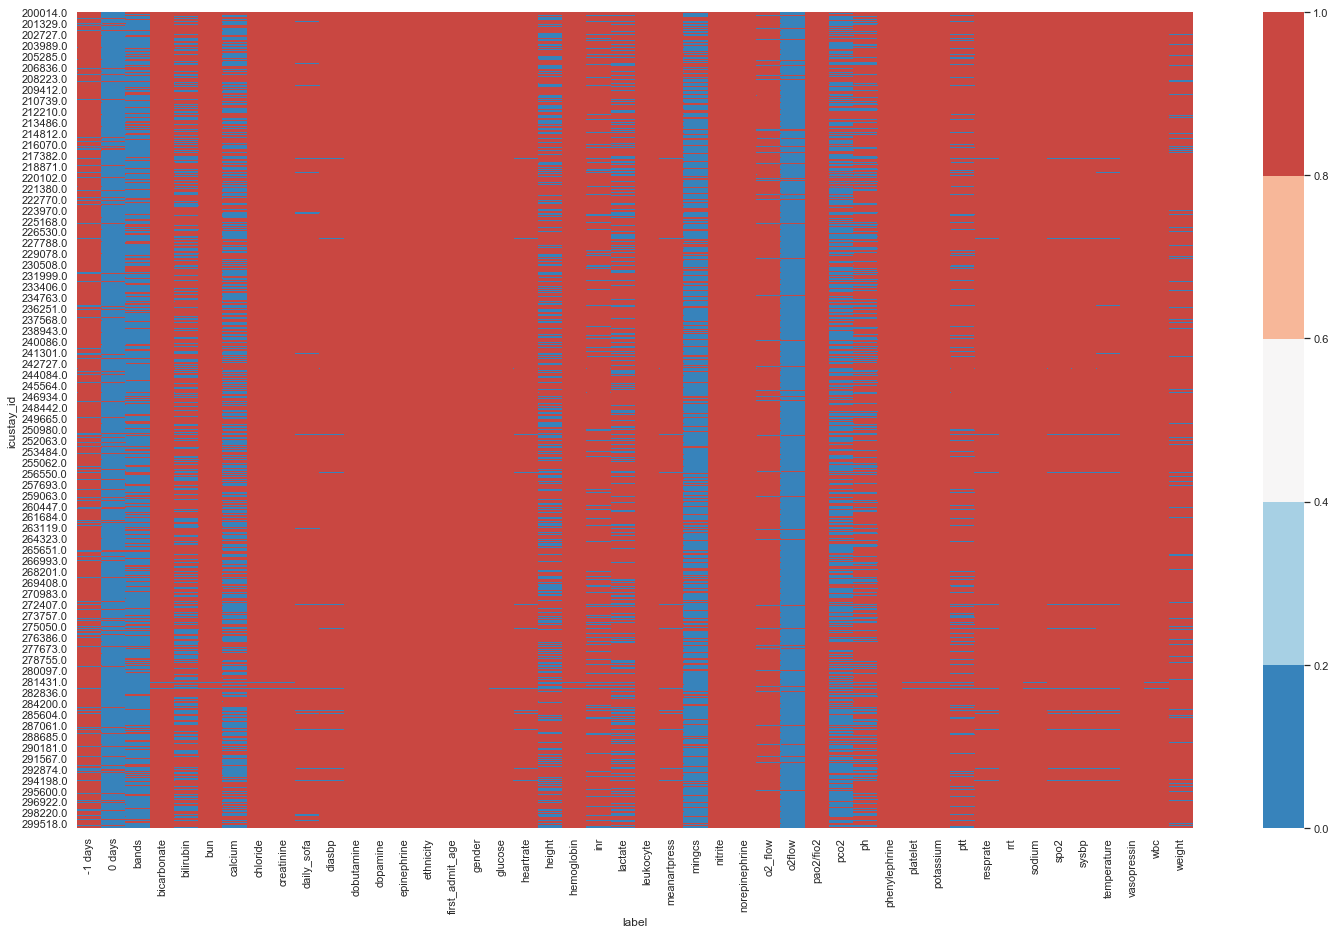

time: 2.01 s


In [142]:
#big_agg_min

#%matplotlib inline

# Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
# Cols = ['A', 'B', 'C', 'D']
# df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.set(rc={'figure.figsize':(25,15)})
big_agg_count= big_agg_count.fillna(0)
big_agg_count = big_agg_count[big_agg_count.columns].astype(float) 


sns.heatmap(big_agg_count,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

In [143]:
###f

time: 533 µs


In [144]:
len(list(big_agg_count)) #38 columns. 

46

time: 1.9 ms


In [145]:
big_agg_count

label,-1 days,0 days,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,...,ptt,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200014.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,38.0,1.0,2.0,34.0,38.0,30.0,1.0,2.0,1.0
200019.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,...,2.0,47.0,1.0,2.0,43.0,38.0,11.0,1.0,2.0,1.0
200030.0,1.0,0.0,0.0,3.0,0.0,3.0,1.0,3.0,3.0,3.0,...,2.0,49.0,1.0,3.0,49.0,51.0,16.0,1.0,2.0,1.0
200033.0,1.0,0.0,0.0,7.0,1.0,7.0,2.0,7.0,7.0,3.0,...,2.0,55.0,1.0,7.0,50.0,51.0,12.0,1.0,4.0,1.0
200055.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,...,2.0,27.0,1.0,3.0,27.0,25.0,6.0,1.0,2.0,1.0
200061.0,1.0,0.0,0.0,3.0,2.0,3.0,0.0,3.0,3.0,3.0,...,1.0,31.0,1.0,3.0,31.0,28.0,9.0,1.0,2.0,1.0
200063.0,1.0,0.0,0.0,2.0,0.0,2.0,10.0,2.0,2.0,3.0,...,0.0,49.0,1.0,2.0,50.0,52.0,21.0,1.0,2.0,0.0
200065.0,1.0,0.0,3.0,11.0,4.0,11.0,11.0,11.0,11.0,3.0,...,7.0,38.0,1.0,11.0,33.0,34.0,14.0,7.0,8.0,1.0
200075.0,1.0,0.0,0.0,3.0,2.0,3.0,0.0,4.0,3.0,3.0,...,6.0,35.0,1.0,4.0,35.0,34.0,9.0,1.0,2.0,1.0


time: 65.6 ms


In [146]:
big_agg_count[big_agg_count>0] =1
big_agg_pt_missing= big_agg_count.T.apply(lambda x:100*(len(list(big_agg_count))-sum(x))/len(list(big_agg_count)))
big_agg_pt_missing= pd.DataFrame(big_agg_pt_missing).rename(index=str, columns={0:'%_of_values_missing'})

time: 493 ms


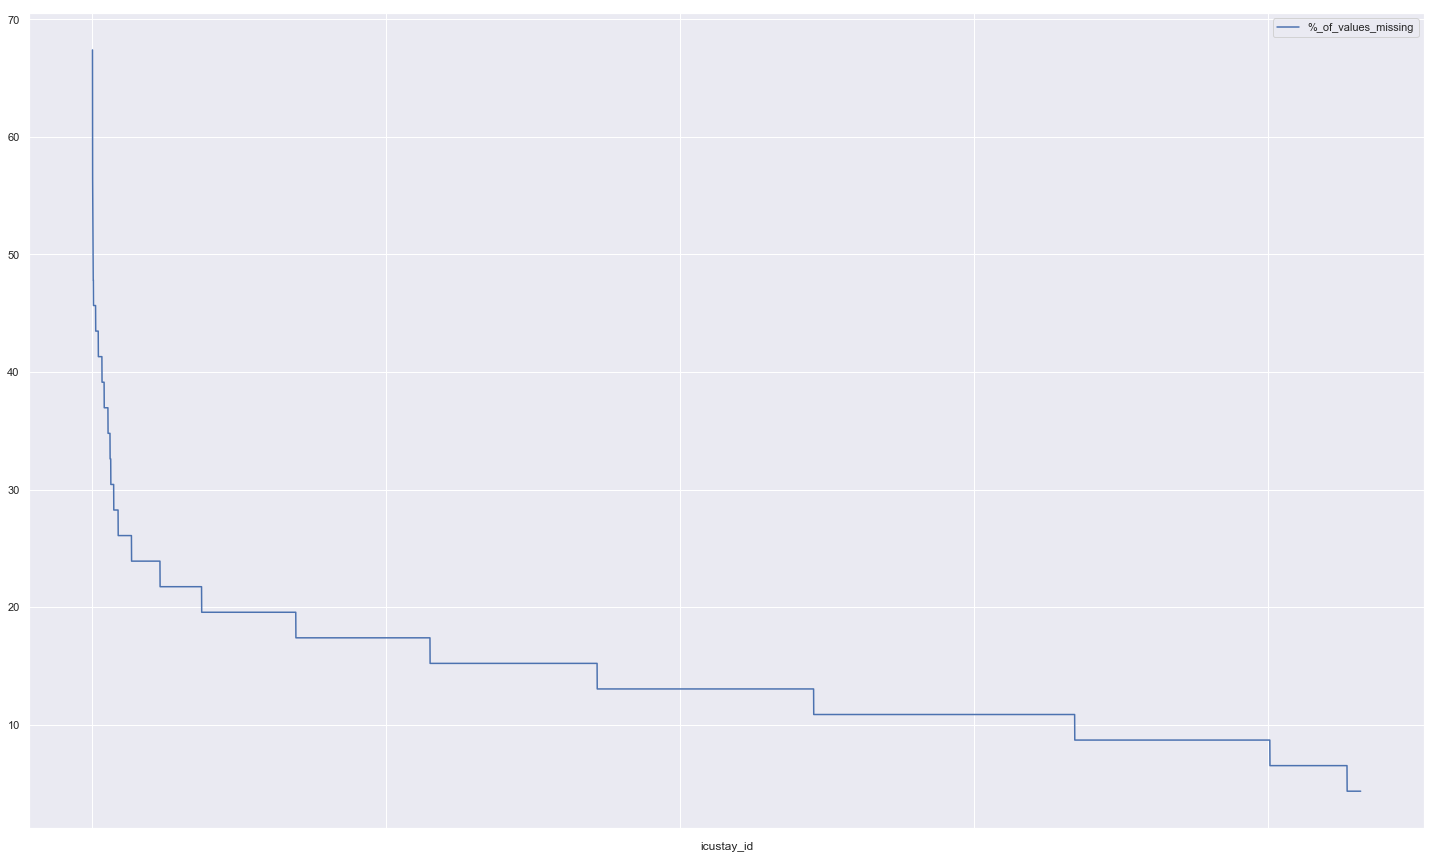

time: 290 ms


In [147]:
big_agg_pt_missing.sort_values('%_of_values_missing',ascending=False).plot()

In [148]:
len(big_agg_pt_missing)

8629

time: 1.96 ms


In [149]:
big_agg_pt_missing.describe()

,%_of_values_missing
count,8629.000000
mean,13.826732
std,5.679608
min,4.347826
25%,10.869565
50%,13.043478
75%,17.391304
max,67.391304


time: 12.5 ms


In [64]:
# def sum_(x):
#     try:
#         return np.sum(x)
#     except:
#         return np.nan

# def max_(x):
#     try:
#         return np.max(x)
#     except:
#         return np.nan

time: 2.09 ms


## data typews

In [65]:
# list1=[]
# list2=[]
# for element in df_list:
#     if 'value' in (list(dfs[element])):
#         list1.append(element)
#     if 'valuenum' in (list(dfs[element])):
#         list2.append(element)




time: 1.79 ms


In [66]:
# for element in list2:
#     print(dfs[element].groupby('label')['valuenum'].describe())

time: 798 µs


In [67]:
# for element in list1:
#     print(dfs[element].groupby('label')['value'].describe())

time: 996 µs


In [68]:
# dfs['bg_ART'].groupby('label')['valuenum'].apply(lambda x: type(x))

time: 689 µs
